In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table
from astropy.io import fits
from astropy import wcs
import seaborn as sns
import pylab as plt



/home/mc741/anaconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. The prior for XID+ is based on IRAC detected sources coming from SWIRE.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_ELAIS-N2/data/holes_ELAIS-N2_irac_i1_O16_20180921_MOC.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_ELAIS-N2_MOC.fits')
Final=Sel_func.intersection(SWIRE_MOC)

In [3]:
#Final.write('./data/testMoc.fits', overwrite=True)

## Read in XID+MIPS catalogue

In [4]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_ELAIS-N2/data/output/dmu26_XID+MIPS_ELAIS-N2_SWIRE_cat_20181108.fits')

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J163346.992+394243.420,248.445799537607,39.712061083265695,14.360089,28.563936,5.267528,-0.00041493773,5.2701807e-06,nan,801.0,0.0,True
HELP_J163354.120+394351.612,248.475501874607,39.7310033402657,25.430574,40.34344,11.7319975,0.0006374985,5.1512056e-06,nan,2000.0,0.0,False
HELP_J163352.386+394403.444,248.468276218376,39.7342898946138,125.43618,140.12993,109.88434,0.0006374985,5.1512056e-06,1.0011711,2000.0,0.0,False
HELP_J163352.492+394246.993,248.468716218376,39.7130536946138,262.72702,276.2755,247.86346,0.0006374985,5.1512056e-06,0.9981907,2000.0,0.0,False
HELP_J163352.915+394257.838,248.470479318376,39.7160660946138,71.052124,83.45411,59.446747,0.0006374985,5.1512056e-06,nan,2000.0,0.0,False
HELP_J163350.599+394301.108,248.460827683607,39.71697437126569,117.74637,131.73906,103.897964,0.0006374985,5.1512056e-06,0.9987709,2000.0,0.0,False
HELP_J163353.384+394244.961,248.472431358607,39.712489031265704,3.9729717,9.538257,1.1805742,0.0006374985,5.1512056e-06,nan,2000.0,0.0,True
HELP_J163353.119+394332.116,248.47133095060698,39.7255878742657,141.08069,156.3033,126.02507,0.0006374985,5.1512056e-06,nan,2000.0,0.0,False


4.9961205
86


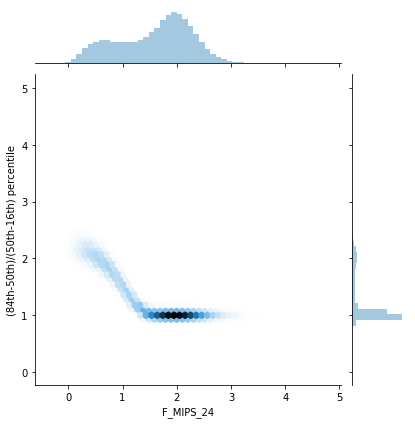

In [6]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))


The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [7]:
good=XID_MIPS['F_MIPS_24']>20

In [8]:
good.sum()

86591

## Read in Maps

In [9]:

#im100fits='../../dmu18/dmu18_ELAIS-N2/data/input_data/ELAIS-N2-100um-img_wgls.fits'#PACS 100 map
#nim100fits='../../dmu18/dmu18_ELAIS-N2/data/input_data/ELAIS-N2-100um-img_noise.fits'#PACS 100 noise map
#im160fits='../../dmu18/dmu18_ELAIS-N2/data/input_data/ELAIS-N2-160um-img_wgls.fits'#PACS 160 map
#nim160fits='../../dmu18/dmu18_ELAIS-N2/data/input_data/ELAIS-N2-160um-img_noise.fits'#PACS 160 noise map


im100fits='../../dmu18/dmu18_HELP-PACS-maps/data/ELAIS-N2_PACS100_v0.9.fits'#PACS 100 map
im160fits='../../dmu18/dmu18_HELP-PACS-maps/data/ELAIS-N2_PACS160_v0.9.fits'#PACS 160 map

#output folder
output_folder='./'

In [10]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im100hdu=hdulist['IMAGE'].header

w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im160hdu=hdulist['IMAGE'].header

w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist.close()

In [11]:
np.shape(im100)

(6675, 7618)

## Read in PSF

In [13]:
pacs100_psf=fits.open('../../dmu18/dmu18_ELAIS-N2/dmu18_PACS_100_PSF_ELAIS-N2_20190124.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_ELAIS-N2/dmu18_PACS_160_PSF_ELAIS-N2_20190124.fits')

print (pacs100_psf)
centre100=np.long((pacs100_psf[0].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[0].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map




In [14]:
print(pind160)

[ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.          8.33333333  8.66666667  9.          9.33333333  9.66666667
 10.         10.33333333 10.66666667 11.         11.33333333 11.66666667
 12.         12.33333333 12.66666667 13.         13.33333333 13.66666667
 14.         14.33333333 14.66666667 15.         15.33333333 15.66666667
 16.         16.33333333 16.66666667]


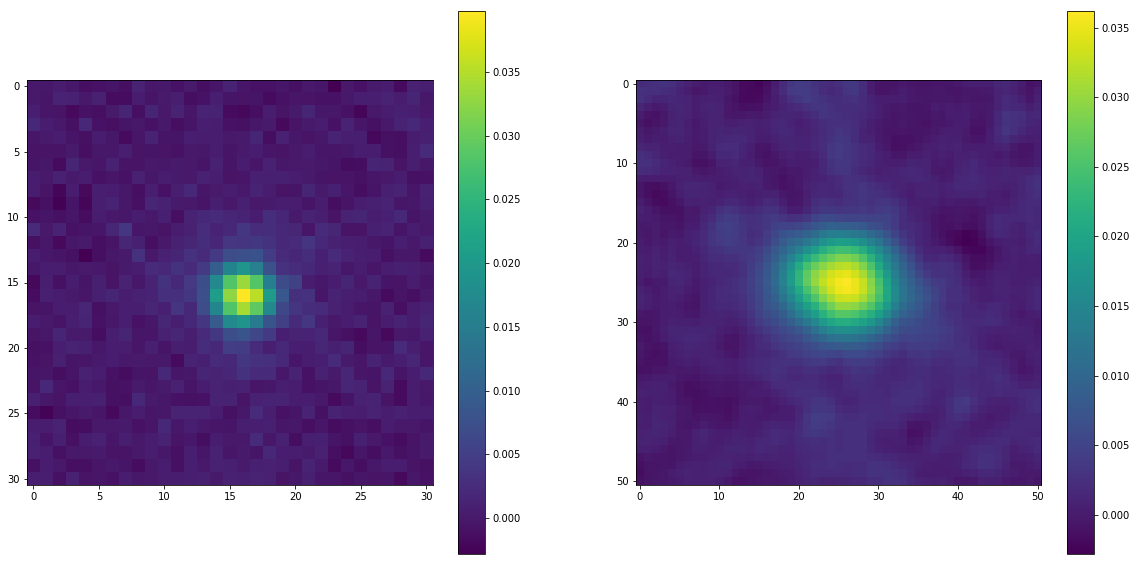

In [15]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()


## Set XID+ prior class

In [16]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N2_SWIRE_cat_20181108.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Final)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N2_SWIRE_cat_20181108.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


In [17]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [18]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
outfile=output_folder+'Master_prior2.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles2.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 5409 tiles required for input catalogue and 13 large tiles


SystemExit: 